# tip

reference:stephanlin

In [66]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from scipy import cluster
from random import randint
import time
data=pd.read_csv("green_tripdata_2015-07.csv")

In [54]:
timestamp = pd.to_datetime(pd.Series(data['lpep_pickup_datetime']))
data['weekday'] = timestamp.dt.weekday_name


#drop unnecessary column
df=data
df = df.drop(['Store_and_fwd_flag','VendorID','Ehail_fee','Unnamed: 23'], axis=1)
df=df.dropna()
df['pickup_hour'] = timestamp.dt.hour
df['tip_percentage'] = df.Tip_amount / df.Trip_distance
df.head()

,lpep_pickup_datetime,Lpep_dropoff_datetime,RateCodeID,Pickup_longitude,Pickup_latitude,Dropoff_longitude,Dropoff_latitude,Passenger_count,Trip_distance,Fare_amount,...,Tolls_amount,improvement_surcharge,Total_amount,Payment_type,Trip_type,PickupCell,DropoffCell,weekday,pickup_hour,tip_percentage
0,2015-07-01 00:01:10,2015-07-01 00:19:04,1,-73.940628,40.715027,-73.912315,40.760380,1,4.33,15.5,...,0.0,0.3,16.80,2,1.0,37:68,36:57,Wednesday,0,0.00000
1,2015-07-01 00:05:35,2015-07-01 00:17:42,1,-73.951134,40.804947,-73.867218,40.818989,1,6.11,18.0,...,0.0,0.3,19.30,1,1.0,25:54,36:42,Wednesday,0,0.00000
2,2015-07-01 00:00:27,2015-07-01 00:03:40,1,-73.873878,40.742409,-73.889275,40.739227,1,0.96,5.0,...,0.0,0.3,6.33,1,1.0,44:55,42:58,Wednesday,0,0.03125
3,2015-07-01 00:00:29,2015-07-01 00:05:30,1,-73.903488,40.745758,-73.905785,40.737576,2,1.04,5.5,...,0.0,0.3,6.80,2,1.0,39:58,40:60,Wednesday,0,0.00000
4,2015-07-01 00:00:22,2015-07-01 00:10:43,1,-73.845810,40.720570,-73.810677,40.701687,1,2.48,10.5,...,0.0,0.3,11.80,2,1.0,51:55,59:54,Wednesday,0,0.00000


In [72]:

def getMaxLocation(location, mile):
    degree = mileToDegree(mile)
    max_locations = []
    max_locations.append({'longitude': location['longitude'] - degree,
                          'latitude': location['latitude'] - degree,})
    max_locations.append({'longitude': location['longitude'] + degree,
                          'latitude': location['latitude'] + degree,})
    return max_locations

In [59]:
def mileToDegree(mile):
    return float("{:.6f}".format(mile/60))



def fit_model(X, y):
    model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(X, y)
    return model

def score_model(model, X, y, Xv, yv):
    return tuple([model.score(X, y), model.score(Xv, yv)])

def fit_model_and_score(data, response, validation, val_response):
    model = fit_model(data, response)
    return score_model(model, data, response, validation, val_response)

In [67]:
def polyRegression(inputs, df):
    # print inputs
    print ('inputs:')
    print ('- Day of Week: %s' %(inputs['day_of_week']))
    print ('- hour: %d' %(inputs['hour']))
    print ('- Driver Location: %s, %s' %(inputs['driver_location']['longitude'], inputs['driver_location']['latitude']))
    print ('- Distance Range: %d-mile' %(inputs['mile']))
    
    # filter data for given inputs
    #max_location = getMaxLocation(inputs['driver_location'], inputs['mile'])
    df_selected = df[
                     (df['pickup_hour'] == inputs['hour']) & 
                     (df['weekday'] == inputs['day_of_week']) &
                     (np.isfinite(df['tip_percentage']))]

    # clustering
    num_clusters = 200
    tips = df_selected['tip_percentage'].values
    lon = df_selected['Pickup_longitude'].values
    lat = df_selected['Pickup_latitude'].values
    coodinate_array = np.array([[lon[i],lat[i],tips[i]] for i in range(len(lon))])
    kmeans_n = KMeans(n_clusters=num_clusters, n_init=1)
    kmeans_n.fit(coodinate_array)
    df_selected['Cluster'] = kmeans_n.labels_
    
    # prepare for regression
    df_selected_cluster = df_selected.groupby('Cluster')
    cluster_tip = df_selected_cluster.tip_percentage.sum() / df_selected_cluster.size()
    cluster_tip = np.array([[cluster_tip[i]] for i in range(len(cluster_tip))])
    cluster_center = kmeans_n.cluster_centers_
    
    # train and test data
    train_size = int(len(cluster_tip)*0.8)
    test_size = int(len(cluster_tip)*0.2)
    train_feature = cluster_tip[:train_size]
    train_response = cluster_center[:train_size]
    test_feature = cluster_tip[test_size:]
    test_response = cluster_center[test_size:]
    
    # validation score
    print ('Coefficient of determination (R^2): ', 
           fit_model_and_score(train_feature, train_response, test_feature, test_response))
    
    MSE_model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                          ('linear', LinearRegression(fit_intercept=False))])
    MSE_model.fit(train_feature, train_response)
    x_MSE = test_feature
    y_MSE = MSE_model.predict(x_MSE)
    print ('MSE: ', mean_squared_error(test_response, y_MSE))
    
    # prediction
    model = Pipeline([('poly', PolynomialFeatures(degree=4)),
                      ('linear', LinearRegression(fit_intercept=False))])
    model.fit(cluster_tip, cluster_center) # x: cluster_tip, y: cluster_center
    x_predict = (max(cluster_tip))
    y_predict = model.predict(x_predict.reshape(-1,1))
 
    # visualization
    result_x = y_predict[0][0]
    result_y = y_predict[0][1]
    plt.figure(figsize=(18,9))
    plt.scatter(lon,lat,alpha=0.2,s=100)
    plt.scatter(result_x,result_y,c='r',s=100)
    plt.scatter(inputs['driver_location']['longitude'],inputs['driver_location']['latitude'],c='w',s=100)
    plt.xlabel('longitude')
    plt.ylabel('latitude')
    plt.show()

inputs:
- Day of Week: Tuesday
- hour: 10
- Driver Location: -73.99134, 40.744712
- Distance Range: 2-mile


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Coefficient of determination (R^2):  (0.9999903063761751, 0.9983424640909826)
MSE:  0.0019387976124126


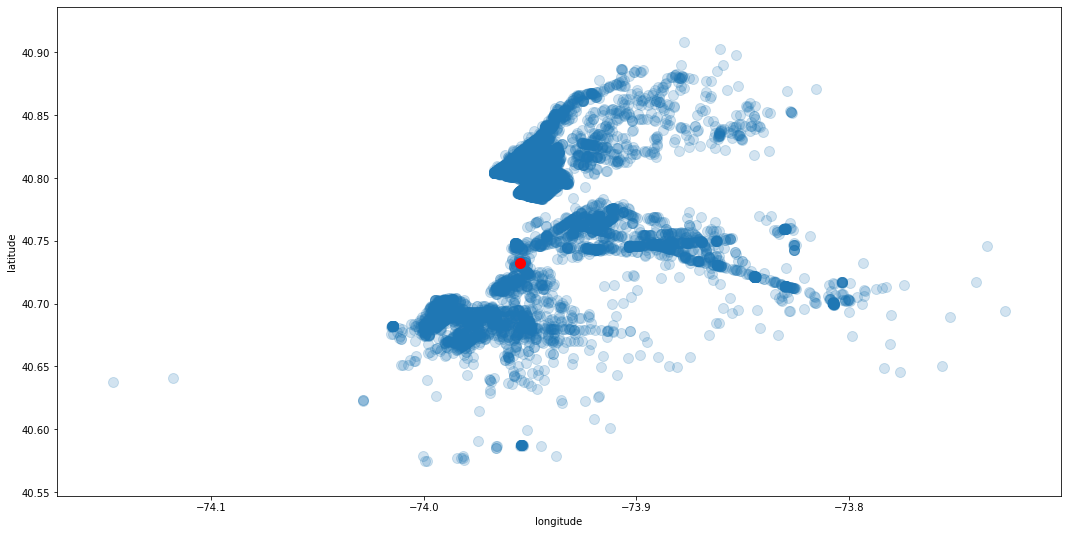

inputs:
- Day of Week: Sunday
- hour: 17
- Driver Location: -73.99134, 40.744712
- Distance Range: 1-mile


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Coefficient of determination (R^2):  (0.9999999688500762, 0.9985257766188376)
MSE:  0.001911423929377799


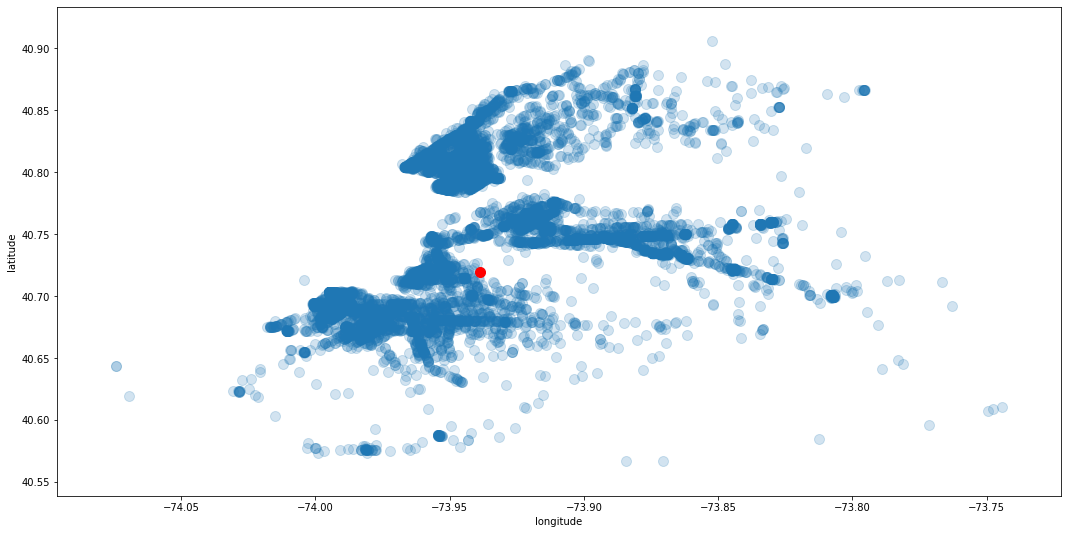

In [71]:
inputs_arr = [
              {'mile': 2,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712},
               'hour': 10,
               'day_of_week': 'Tuesday'},
              {'mile': 1,
               'driver_location': {'longitude': -73.991340,'latitude': 40.744712},
               'hour': 17,
               'day_of_week': 'Sunday'}
             ]
              
for inputs in inputs_arr:
    polyRegression(inputs, df)